# Hello World: The Teacup Model

This notebook demonstrates the basic capability of PySD using a model of a cup of tea cooling to room temperature.  

<img src="../../models/Teacup/Teacup.png" alt="Image of Vensim Teacup Model" style="width: 300px;"/>



Our model simulates [Newton's Law of Cooling](http://www.ugrad.math.ubc.ca/coursedoc/math100/notes/diffeqs/cool.html), which follows the functional form:
$$\frac{dT}{dt} = k(T - T_{ambient})$$

This model has all of the canonical components of a system dynamics model: a stock, a flow, a feedback loop, a control parameter, and exhibits dynamic behavior. The model equations are:

    Characteristic Time=
            10
    Units: Minutes

    Heat Loss to Room=
        (Teacup Temperature - Room Temperature) / Characteristic Time
    Units: Degrees/Minute
    This is the rate at which heat flows from the cup into the room. 

    Room Temperature=
        70
    Units: Degrees

    Teacup Temperature= INTEG (
        -Heat Loss to Room,
            180)
    Units: Degrees
    
    
### Load the model
We begin by importing the PySD module using the python standard import commands. We then use PySD's Vensim model translator to import the model from the Vensim model file and create a model object. We see that PySD translates the vensim component names into acceptable python identifiers.

In [1]:
%pylab inline
import pysd
model = pysd.read_vensim('../../models/Teacup/Teacup.mdl')

Populating the interactive namespace from numpy and matplotlib


The `read_vensim` command we have just run does two things. First it translates the model into a python module which is stored `../../models/Teacup/Teacup.py` in the same directory as the original file, with the filename changed to `.py`. You can go and have a look at the file and compare it to the vensim model file that it came from to get a sense for how the translation works.

The second thing the function does is load that translated python file into a PySD object and return it for use.

### Run with default parameters
To understand the general behavior of the model, we can run a simulation using the default parameters specified by the Vensim model file. The default behavior of the run function is to return the value of all variables as a [pandas](http://pandas.pydata.org/) dataframe:

In [2]:
values = model.run()
values.head(5)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Characteristic Time,Heat Loss to Room,Room Temperature,Teacup Temperature
0.000,30,0,0.125,0.125,10,11.000000,70,180.000000
0.125,30,0,0.125,0.125,10,10.862500,70,178.625000
0.250,30,0,0.125,0.125,10,10.726719,70,177.267188
0.375,30,0,0.125,0.125,10,10.592635,70,175.926348
0.500,30,0,0.125,0.125,10,10.460227,70,174.602268


Pandas has some simple plotting utility built in which allows us to easily visualize the results.

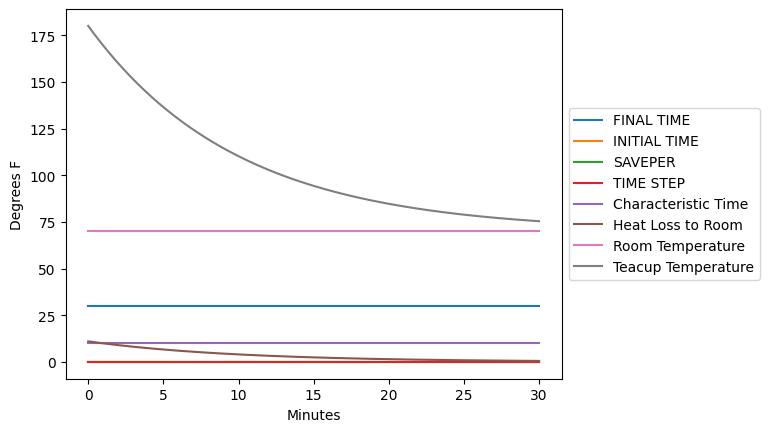

In [3]:
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
plt.legend(loc='center left', bbox_to_anchor=(1,.5));

### Return specific model components

If we wish to see values of only certain variables, we can pass a list of component names with the keyword argument `return_columns`. This will change the columns of the returned dataframe such that they contain samples of the requested model components. This is (very) slightly faster, but often cleaner:

,Teacup Temperature,Room Temperature
0.000,180.000000,70
0.125,178.625000,70
0.250,177.267188,70
0.375,175.926348,70
0.500,174.602268,70


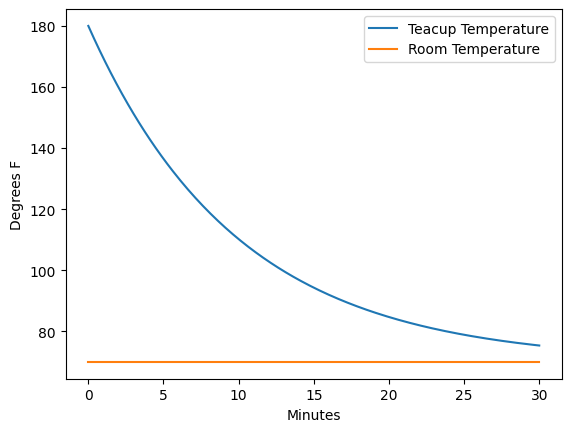

In [4]:
values = model.run(return_columns=['Teacup Temperature', 'Room Temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
values.head()

### Return values at a specific time

Sometimes we want to specify the timestamps that the run function should return values. For instance, if we are comparing the result of our model with data that arrives at irregular time intervals. We can do so using the `return_timestamps` keyword argument. This argument expects a list of timestamps, and will return values at those timestamps.

,Teacup Temperature
0.0,180.000000
1.0,169.469405
3.0,151.336071
7.0,124.383922
9.5,112.287559


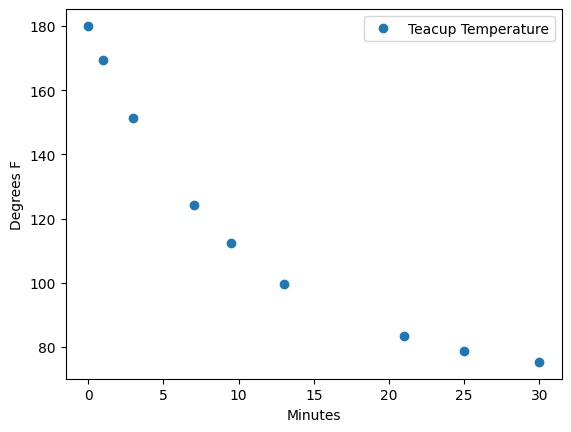

In [5]:
stocks = model.run(return_timestamps=[0,1,3,7,9.5, 13, 21, 25, 30],
                   return_columns=['Teacup Temperature'])
stocks.plot(linewidth=0, marker='o')
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
stocks.head()

### Modify parameter values
We can specify changes to the parameters of the model in the call to the run function. Here we set the room temperature to the constant value of 20 degrees before running the simulation.

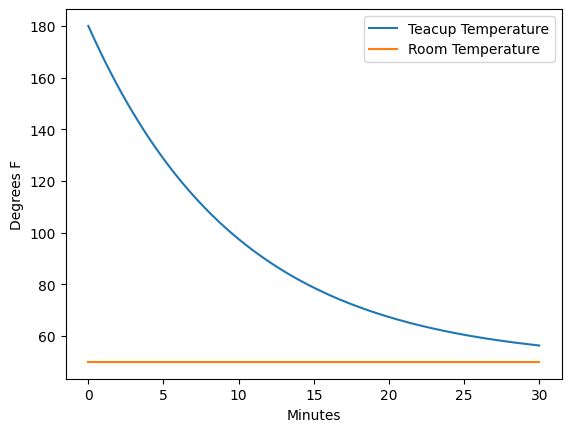

In [6]:
values = model.run(params={'Room Temperature':50}, 
                   return_columns=['Teacup Temperature', 'Room Temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

We can also specify that a parameter be set with a time-varying input. In this case, we raise the room temperature from 20 to 80 degrees over the course of the 30 minutes. We can see that once the room temperature rises above that of the tea, the tea begins to warm up again.

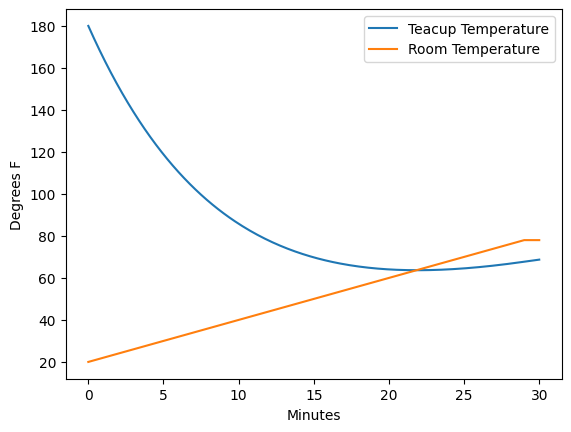

In [7]:
import pandas as pd
temp_timeseries = pd.Series(index=range(30), data=range(20,80,2))
values = model.run(params={'Room Temperature':temp_timeseries},
                   return_columns=['Teacup Temperature', 'Room Temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

Note that when you set a variable equal to a value, you overwrite the existing formula for that variable. This means that if you assign a value to a variable which is computed based upon other variable values, you will break those links in the causal structure. This can be helpful when you wish to isolate part of a model structure, or perform loop-knockout analysis, but can also lead to mistakes. To return to the original model structure, you'll need to reload the model.

### Specifying model initial conditions

In addition to parameters, we can set the initial conditions for the model, by passing a tuple to the argument `initial_condition`. In this case, the first element of the tuple is the time at which the model should begin its execution, and the second element of the tuple is a dictionary containing the values of the stocks at that particular time. 

Note again that this is a different syntax from merely sending a new value to the stock using the `params` syntax, which could cause unintended behavior as previously described.

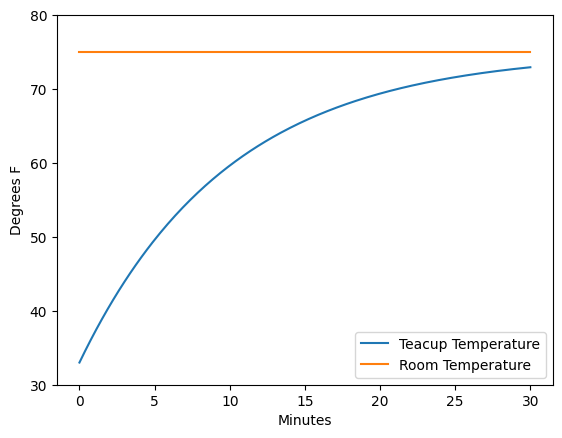

In [8]:
stocks = model.run(params={'room_temperature':75},
                   initial_condition=(0, {'teacup_temperature':33}),
                   return_columns=['Teacup Temperature', 'Room Temperature'])
stocks.plot()
plt.ylabel('Degrees F')
plt.ylim(30,80)
plt.xlabel('Minutes');

Once a model has been run, we can choose to run it forwards again from its current state. To do this we specify a new set of timestamps over which we would like the model to run, and pass the `intitial_condition` argument the string `"current"`.

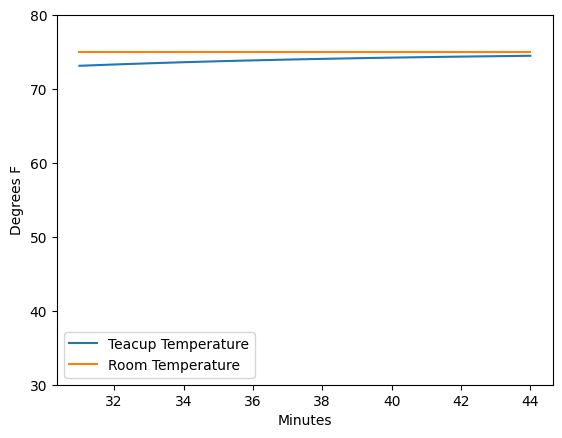

In [9]:
values = model.run(initial_condition='current', 
                   return_columns=['Teacup Temperature', 'Room Temperature'],
                   return_timestamps=list(range(31,45)))
values.plot()
plt.ylabel('Degrees F')
plt.ylim(30,80)
plt.xlabel('Minutes');